## Recurrent Neural Networks

Author: Calvin Chan 

### Introduction 

In this final notebook we will look at an advance model known as Recurrent Neural Networks or RNNs. We will be utilizing Gated Reccurent Units or (GRUs) in our model. Since our data consists of time series, we expect RNNs to work much better since they are meant for processing data such as ours. First we will import our full data set and add some minor changes such as reducing the data from multiclass to binary classification. 

In [1]:
import sys

print(sys.executable)

/Users/ChanFamily/opt/anaconda3/envs/ecgcap/bin/python3.8


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pickle
import load_functions as f
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization, LeakyReLU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

In [4]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [5]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [6]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

### Binary Classification

In [7]:
def binary(diagnostic_list):
    if ast.literal_eval(diagnostic_list) != ['NORM']:
        diagnostic_list = 'ABNO'
    else:
        diagnostic_list = 'NORM'
    return diagnostic_list

In [8]:
y = y.apply(lambda x: binary(x))

In [9]:
y.value_counts()

ABNO    8645
NORM    7032
Name: diagnostic_superclass, dtype: int64

In [10]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

# Transform target column 
y = label.transform(y)

In [11]:
label.transform(['ABNO', 'NORM'])

array([0, 1])

In [12]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal

signal_bl = pd.DataFrame(X).apply(lambda x: c.baseline_removal(x, freq_start=0.1, freq_stop=1.5))
signal_pli = pd.DataFrame(signal_bl).apply(lambda x: c.high_freq_removal(x, freq_start=45))

In [13]:
# Reshape it into 3D 
signal_pli = signal_pli.values.reshape(-1, 1000, 1).astype("float")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000, 1), (12541,))

In [15]:
X_test.shape, y_test.shape

((3136, 1000, 1), (3136,))

### First Model 

In this first model, we will use a softmax output layer and sparse categorical cross entropy.

In [126]:
rnn_model = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(2, activation='softmax')],
)

In [127]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [130]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Fit our model, adding a validation set as well 
history = rnn_model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=10, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/10
353/353 [==============================] - 184s 512ms/step - loss: 0.6505 - sparse_categorical_accuracy: 0.6165 - val_loss: 1.5967 - val_sparse_categorical_accuracy: 0.4590
Epoch 2/10
353/353 [==============================] - 175s 495ms/step - loss: 0.4706 - sparse_categorical_accuracy: 0.7805 - val_loss: 0.4346 - val_sparse_categorical_accuracy: 0.8207
Epoch 3/10
353/353 [==============================] - 174s 494ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.7960 - val_loss: 0.7993 - val_sparse_categorical_accuracy: 0.6279
Epoch 4/10
353/353 [==============================] - 184s 521ms/step - loss: 0.4356 - sparse_categorical_accuracy: 0.8058 - val_loss: 0.4306 - val_sparse_categorical_accuracy: 0.8104
Epoch 5/10
353/353 [==============================] - 179s 508ms/step - loss: 0.4221 - sparse_categorical_accuracy: 0.8091 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.5896
Epoch 6/10
353/353 [==============================] - 184s 523ms/step - loss: na

In [131]:
rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 1000, 16)          912       
                                                                 
 batch_normalization_36 (Bat  (None, 1000, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 1000, 16)          0         
                                                                 
 gru_25 (GRU)                (None, 16)                1632      
                                                                 
 batch_normalization_37 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 16)              

In [136]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][3]
result = rnn_model.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8058
Test Accuracy: 0.8010


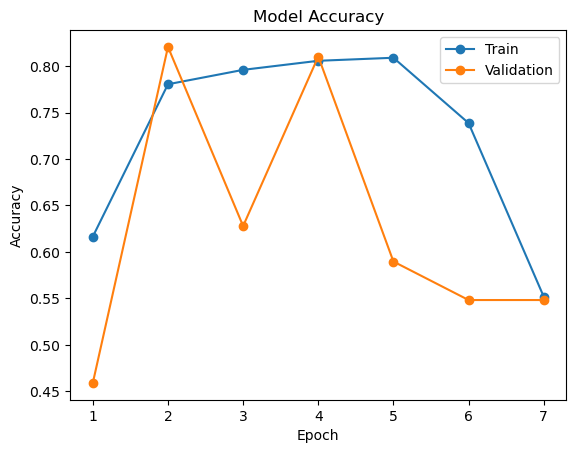

In [155]:
epochs = range(1, 8)

# Plotting accuracy function 
plt.plot(epochs, history.history['sparse_categorical_accuracy'], marker='o')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

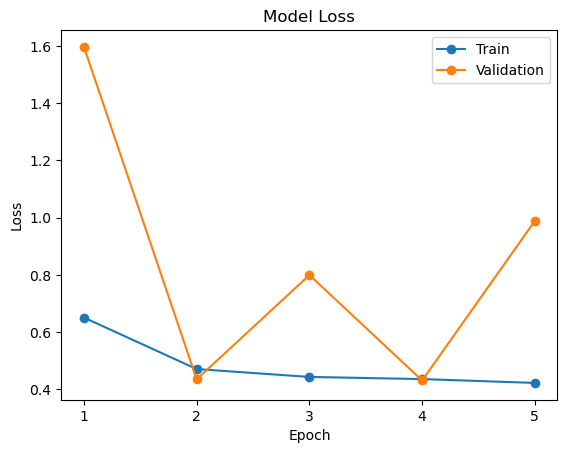

In [156]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

> Only shows for 5 epochs because last two epochs are `NaN`, possibly because of vanishing gradients. If we look at the previous loss values, we see that it appears to hit a plateau, suggesting vanishing loss. 

In [149]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1525,204
True Normal,420,987


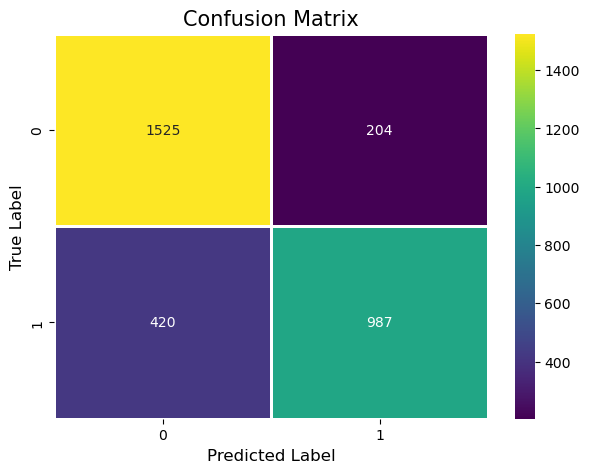

In [179]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [154]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1729
           1       0.83      0.70      0.76      1407

    accuracy                           0.80      3136
   macro avg       0.81      0.79      0.79      3136
weighted avg       0.80      0.80      0.80      3136



In [167]:
y_test.shape

(3136,)

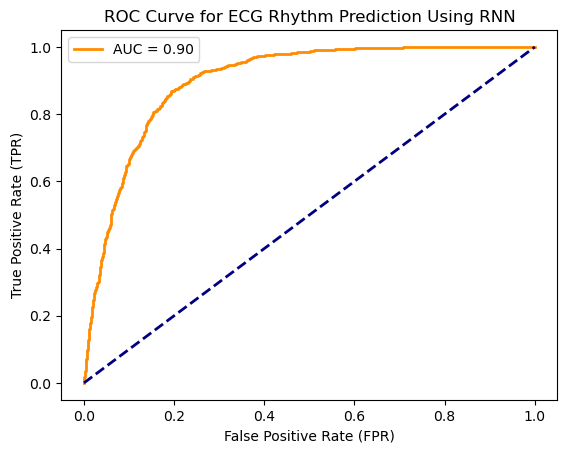

Area under curve (AUC):0.9013817140851144



In [184]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 1])
roc_auc = roc_auc_score(y_test, predict_probas[:, 1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

| Model | Activation             | Loss | LR    | Train Accuracy | Test Accuracy | AUC |
|-------|------------------------|------|-------|----------------|---------------|-----|
| 1     | relu, softmax          | SCCE | 0.01  | 80.58          | 80.10         | 90  |

#### Save model as pickle

- https://edwarda-johnson.medium.com/ai-as-ghostwriter-different-ways-to-save-your-machine-learning-model-f8d4432e893

We can save our models as pickle files for using them to predict in the future using the following code below. 

In [185]:
with open('rnn_binary2.pkl', 'wb') as file:
    pickle.dump(rnn_model, file)

2024-04-12 02:18:25.022445: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ec41f544-4f6b-4245-80e0-bc216df8a94b/assets


To reload our model, we can use the following code: 

In [4]:
new_model = open('rnn_binary.pkl', 'rb')
new_rnn_model = pickle.load(new_model)

2024-04-12 13:41:32.244563: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model 2

In [18]:
rnn_model_2 = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(1, activation='sigmoid')],
)

In [19]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model_2.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.005),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.Recall()]
)

In [20]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Fit our model, adding a validation set as well 
history = rnn_model_2.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=10, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/10
353/353 [==============================] - 185s 517ms/step - loss: 0.6893 - binary_accuracy: 0.5619 - recall_1: 0.3438 - val_loss: 0.6758 - val_binary_accuracy: 0.5402 - val_recall_1: 0.0511
Epoch 2/10
353/353 [==============================] - 177s 502ms/step - loss: 0.5839 - binary_accuracy: 0.6823 - recall_1: 0.6400 - val_loss: 0.6300 - val_binary_accuracy: 0.6398 - val_recall_1: 0.2787
Epoch 3/10
353/353 [==============================] - 176s 499ms/step - loss: 0.5187 - binary_accuracy: 0.7477 - recall_1: 0.7521 - val_loss: 0.4628 - val_binary_accuracy: 0.7809 - val_recall_1: 0.9136
Epoch 4/10
353/353 [==============================] - 178s 505ms/step - loss: 0.4527 - binary_accuracy: 0.7930 - recall_1: 0.8066 - val_loss: 0.3993 - val_binary_accuracy: 0.8271 - val_recall_1: 0.8501
Epoch 5/10
353/353 [==============================] - 177s 501ms/step - loss: 0.4201 - binary_accuracy: 0.8155 - recall_1: 0.8359 - val_loss: 0.5327 - val_binary_accuracy: 0.7522 - val_recall_

In [21]:
rnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1000, 16)          912       
                                                                 
 batch_normalization_3 (Batc  (None, 1000, 16)         64        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1000, 16)          0         
                                                                 
 gru_3 (GRU)                 (None, 16)                1632      
                                                                 
 batch_normalization_4 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 16)               

| Model | Activation             | Loss | LR    | Train Accuracy | Test Accuracy | AUC | File   |
|-------|------------------------|------|-------|----------------|---------------|-----|--------|
| 1     | relu, softmax          | SCCE | 0.01  | 80.58          | 80.10         | 90  | model  |
| 2     | relu, sigmoid, softmax | SCCE | 0.01  | 71.29          | 74.90         | --- | ------ | 
| 3     | relu, sigmoid          | SCCE | 0.005 | 81.24          | 82.53         | 70  | model2 |
| 4     | relu, sigmoid          | BCE  | 0.005 | 82.01          | 80.74         | 88  | model3 |

In [24]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmin(history.history['val_loss'])]
result = rnn_model_2.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8201
Test Accuracy: 0.8074


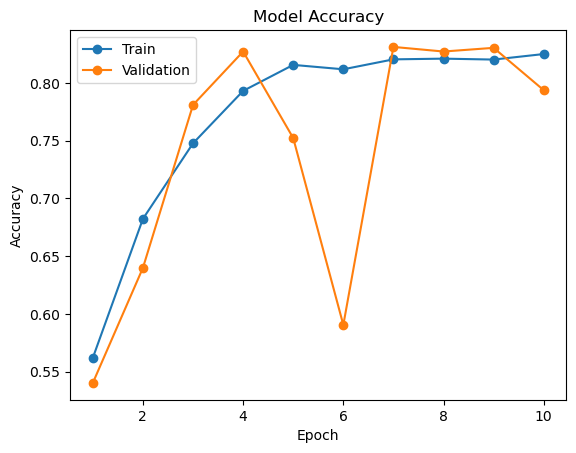

In [26]:
epochs = range(1, 11)

# Plotting accuracy function 
plt.plot(epochs, history.history['binary_accuracy'], marker='o')
plt.plot(epochs, history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

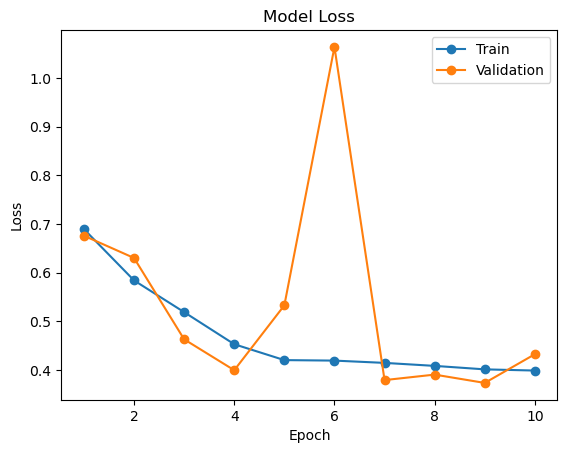

In [27]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

> Only shows for 5 epochs because last two epochs are `NaN`, possibly because of vanishing gradients. If we look at the previous loss values, we see that it appears to hit a plateau, suggesting vanishing loss. 

In [50]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_2.predict(X_test)
binary_array = (predict_probas > 0.5).astype(int).reshape(-1) # Binary classification requires only has 1 output
#y_predict = np.argmax(predict_probas, axis=0)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, binary_array)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1392,337
True Normal,267,1140


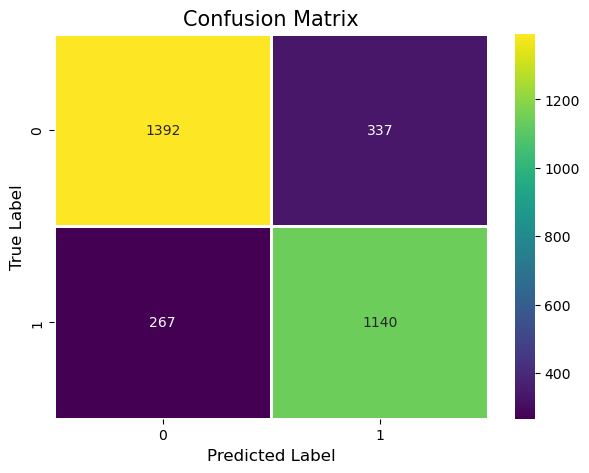

In [52]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [53]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1729
           1       0.77      0.81      0.79      1407

    accuracy                           0.81      3136
   macro avg       0.81      0.81      0.81      3136
weighted avg       0.81      0.81      0.81      3136



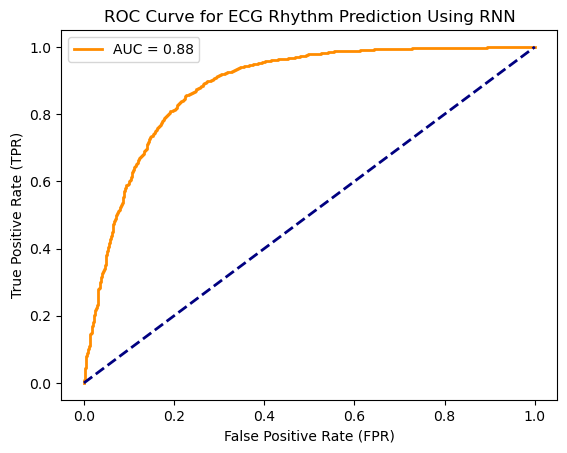

Area under curve (AUC):0.8821964703459485



In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [59]:
with open('rnn_binary3.pkl', 'wb') as file:
    pickle.dump(rnn_model_2, file)

2024-04-13 21:59:21.864869: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://33f18296-d1c6-4f32-9fdf-35d2127231de/assets


### Using GridSearchCV

Below we use a gridsearch to try to look for the best performing model parameters. We utilize another package known as `scikeras`. 

In [16]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Setting random seed for reproducibility
tf.random.set_seed(42)

`scikeras` has a specific format for using `GridSearchCV` with, we will follow the guide outlined [here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) for different parameter optimizations. First we need to create a function that creates our neural network when called upon. 

In [69]:
def create_model():
    
    # Create model
    model = keras.Sequential()
    # the intermediate recurrent layers should return full sequences
    model.add(GRU(16, activation='relu', input_shape=(1000, 1), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    # the last recurrent layer only returns the final output
    model.add(GRU(16, activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    # output layer
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.005),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
    )
    
    return model

We set out callback requirements and parameter grid. 

In [70]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Set our parameter grid with different batch sizes, epochs and learning rate
param_grid = dict(batch_size=[16, 32, 64, 128], 
                  epochs=[10, 20, 40, 80], 
                  optimizer__learning_rate=[0.001, 0.005, 0.01, 0.1])

# Create an instance of the KerasClassifier to be used in GridSearchCV
models = KerasClassifier(model=create_model, validation_split=0.1)

Next, we initialize the grid itself and fit it to our training data. 

In [ ]:
# Initialize grid
grid = GridSearchCV(estimator=models, param_grid=param_grid, cv=5)

# Fit grid
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
565/565 [==============================] - 273s 479ms/step - loss: 0.7032 - binary_accuracy: 0.5442 - val_loss: 0.7221 - val_binary_accuracy: 0.4462
Epoch 2/10
565/565 [==============================] - 277s 489ms/step - loss: nan - binary_accuracy: 0.5551 - val_loss: nan - val_binary_accuracy: 0.5478
Epoch 3/10
565/565 [==============================] - 282s 499ms/step - loss: nan - binary_accuracy: 0.5518 - val_loss: nan - val_binary_accuracy: 0.5478
Epoch 4/10
 49/565 [=>............................] - ETA: 4:21 - loss: nan - binary_accuracy: 0.5804

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
rnn_model_3.summary()

In [ ]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][5]
result = rnn_model_3.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

In [ ]:
epochs = range(1, 10)

# Plotting accuracy function 
plt.plot(epochs, history.history['sparse_categorical_accuracy'], marker='o')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_2.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [ ]:
cr = classification_report(y_test, y_predict)
print(cr)

In [ ]:
fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 1])
roc_auc = roc_auc_score(y_test, predict_probas[:, 1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()